In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# 1. DATA COLLECTION

In [2]:
# fetching dataset from UCI repository
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)

# data (as pandas dataframes)
X = predict_students_dropout_and_academic_success.data.features
y = predict_students_dropout_and_academic_success.data.targets

print("Dataset successfully loaded:")
print("Number of student records:", X.shape[0])
print("Number of features:", X.shape[1])
print("Target distribution:\n", y['Target'].value_counts())

Dataset successfully loaded:
Number of student records: 4424
Number of features: 36
Target distribution:
 Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64


- concatenating the data

In [4]:
df = pd.concat([X, y], axis=1)
df.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


### saving a copy of the data

In [5]:
df.to_csv("student_data.csv", index=False)

## checking for missing values

In [6]:
print("Missing values in the data:", df.isnull().sum().sum())

Missing values in the data: 0


### checking for outliers

In [7]:
numerical_columns = df.select_dtypes(exclude="object")

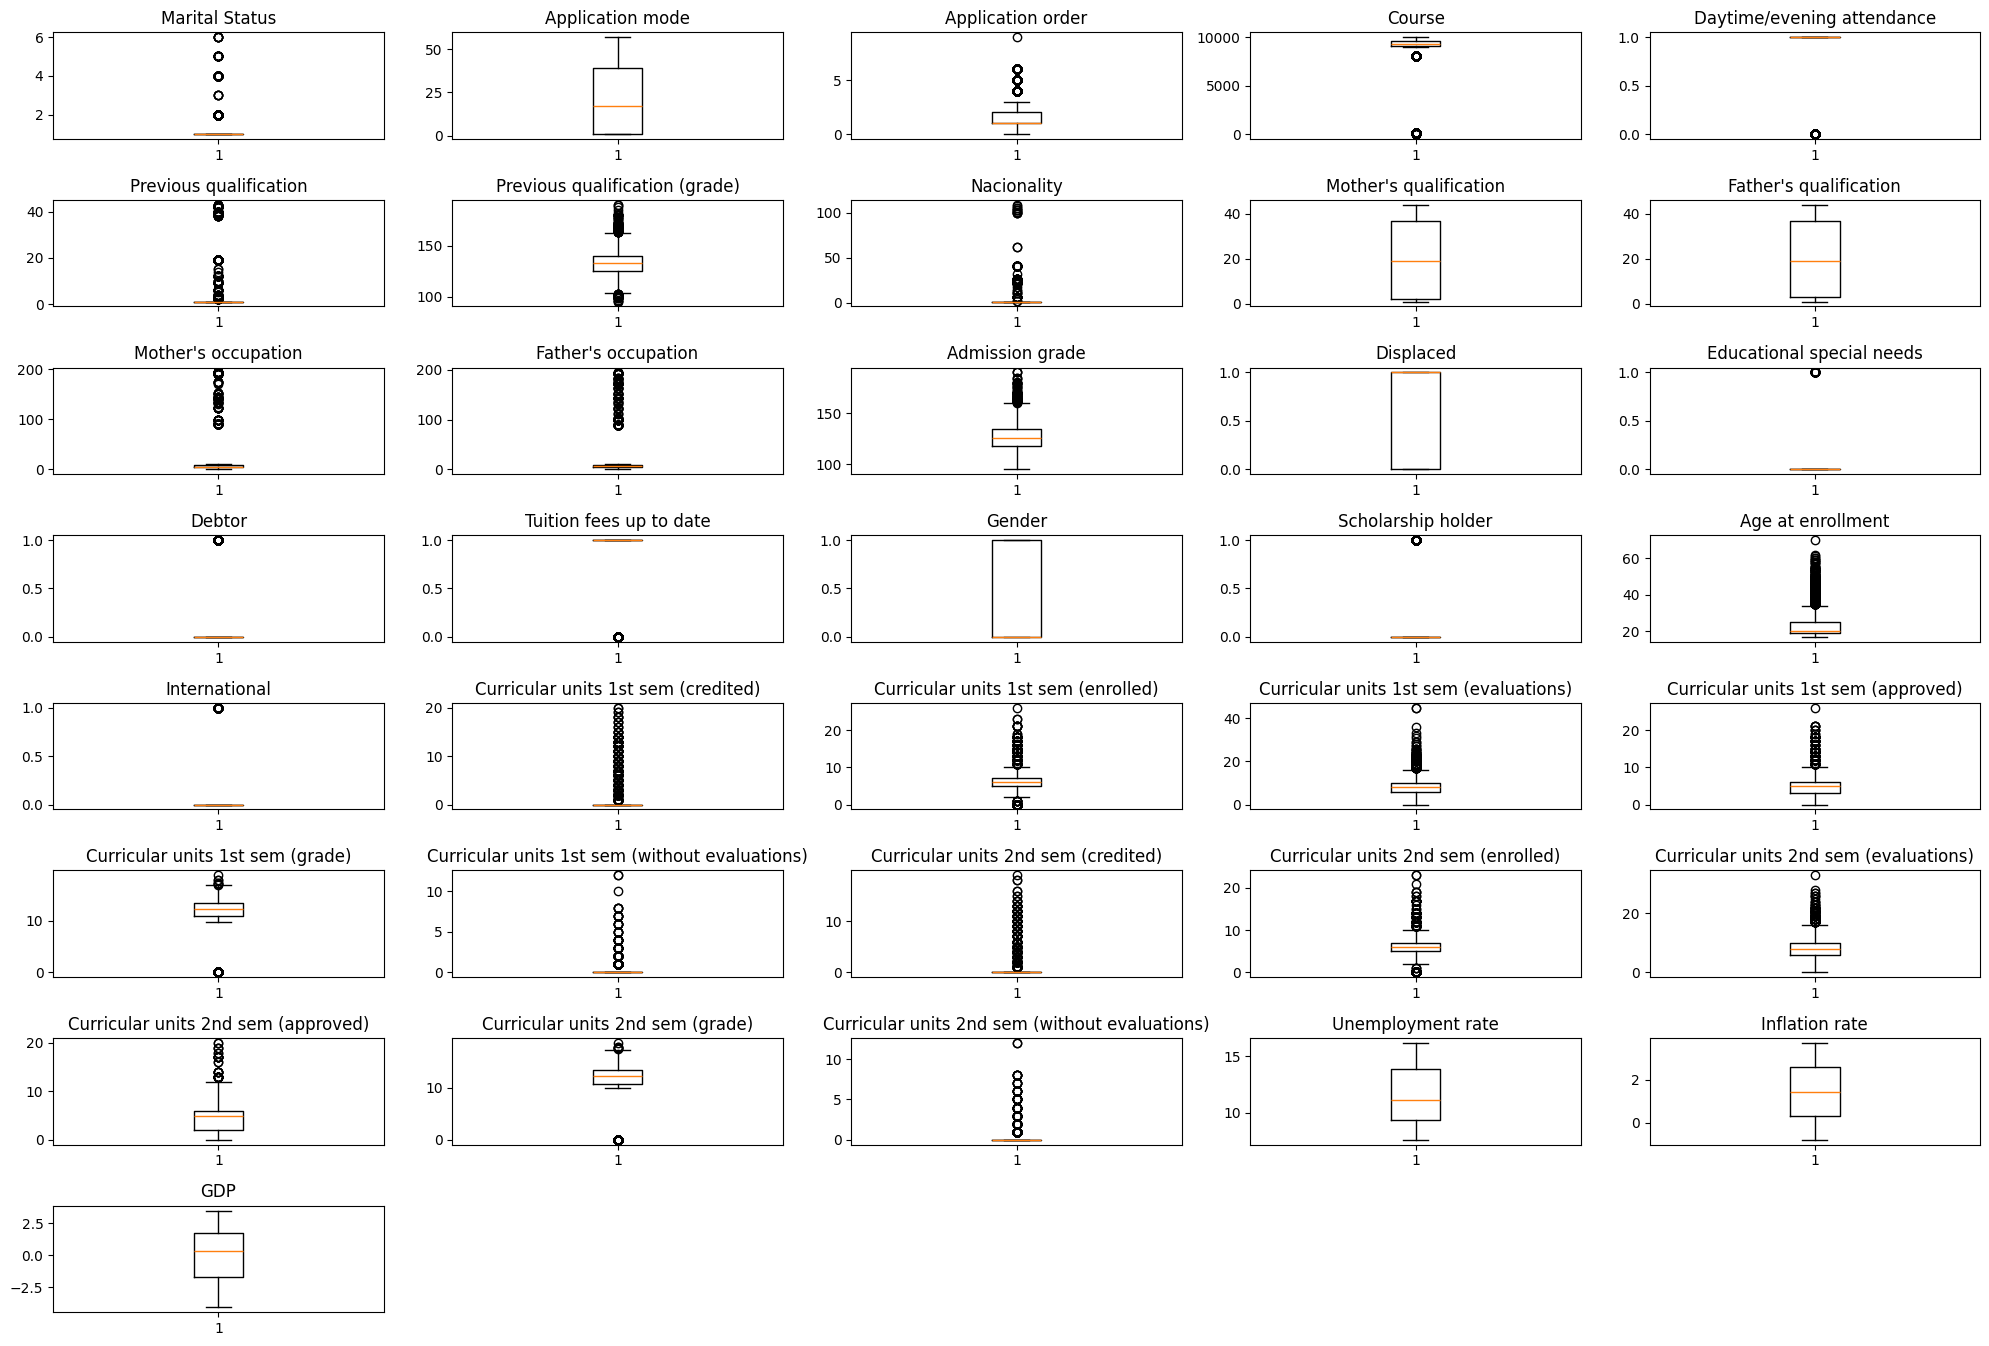

In [8]:
plt.figure(figsize=(20,15))
for i,col in enumerate(numerical_columns.columns):
    plt.subplot(9,5,i+1)
    plt.boxplot(df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [9]:
df.columns

Index(['Marital Status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd s

- renaming columns that have` ' ` in them

In [10]:
df.columns = df.columns.str.replace("'", "_", regex=True)

### Removing outliers for columns that are not binary

In [11]:
def remove_outliers(data, columns):
    for col in columns:
        lower_quantile = data[col].quantile(.25)
        upper_quantile = data[col].quantile(.75)

        IQR = upper_quantile - lower_quantile

        lower_boundary = lower_quantile - 1.5 * IQR
        upper_boundary = upper_quantile + 1.5 * IQR

        data[col] = np.where(data[col]>upper_boundary, upper_boundary, data[col])
        data[col] = np.where(data[col]<lower_boundary, lower_boundary, data[col])

In [12]:
columns = ['Application order','Course','Previous qualification (grade)', 'Mother_s occupation', 'Father_s occupation', 'Admission grade'
           ,'Age at enrollment',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',

       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       ]

remove_outliers(df,columns)

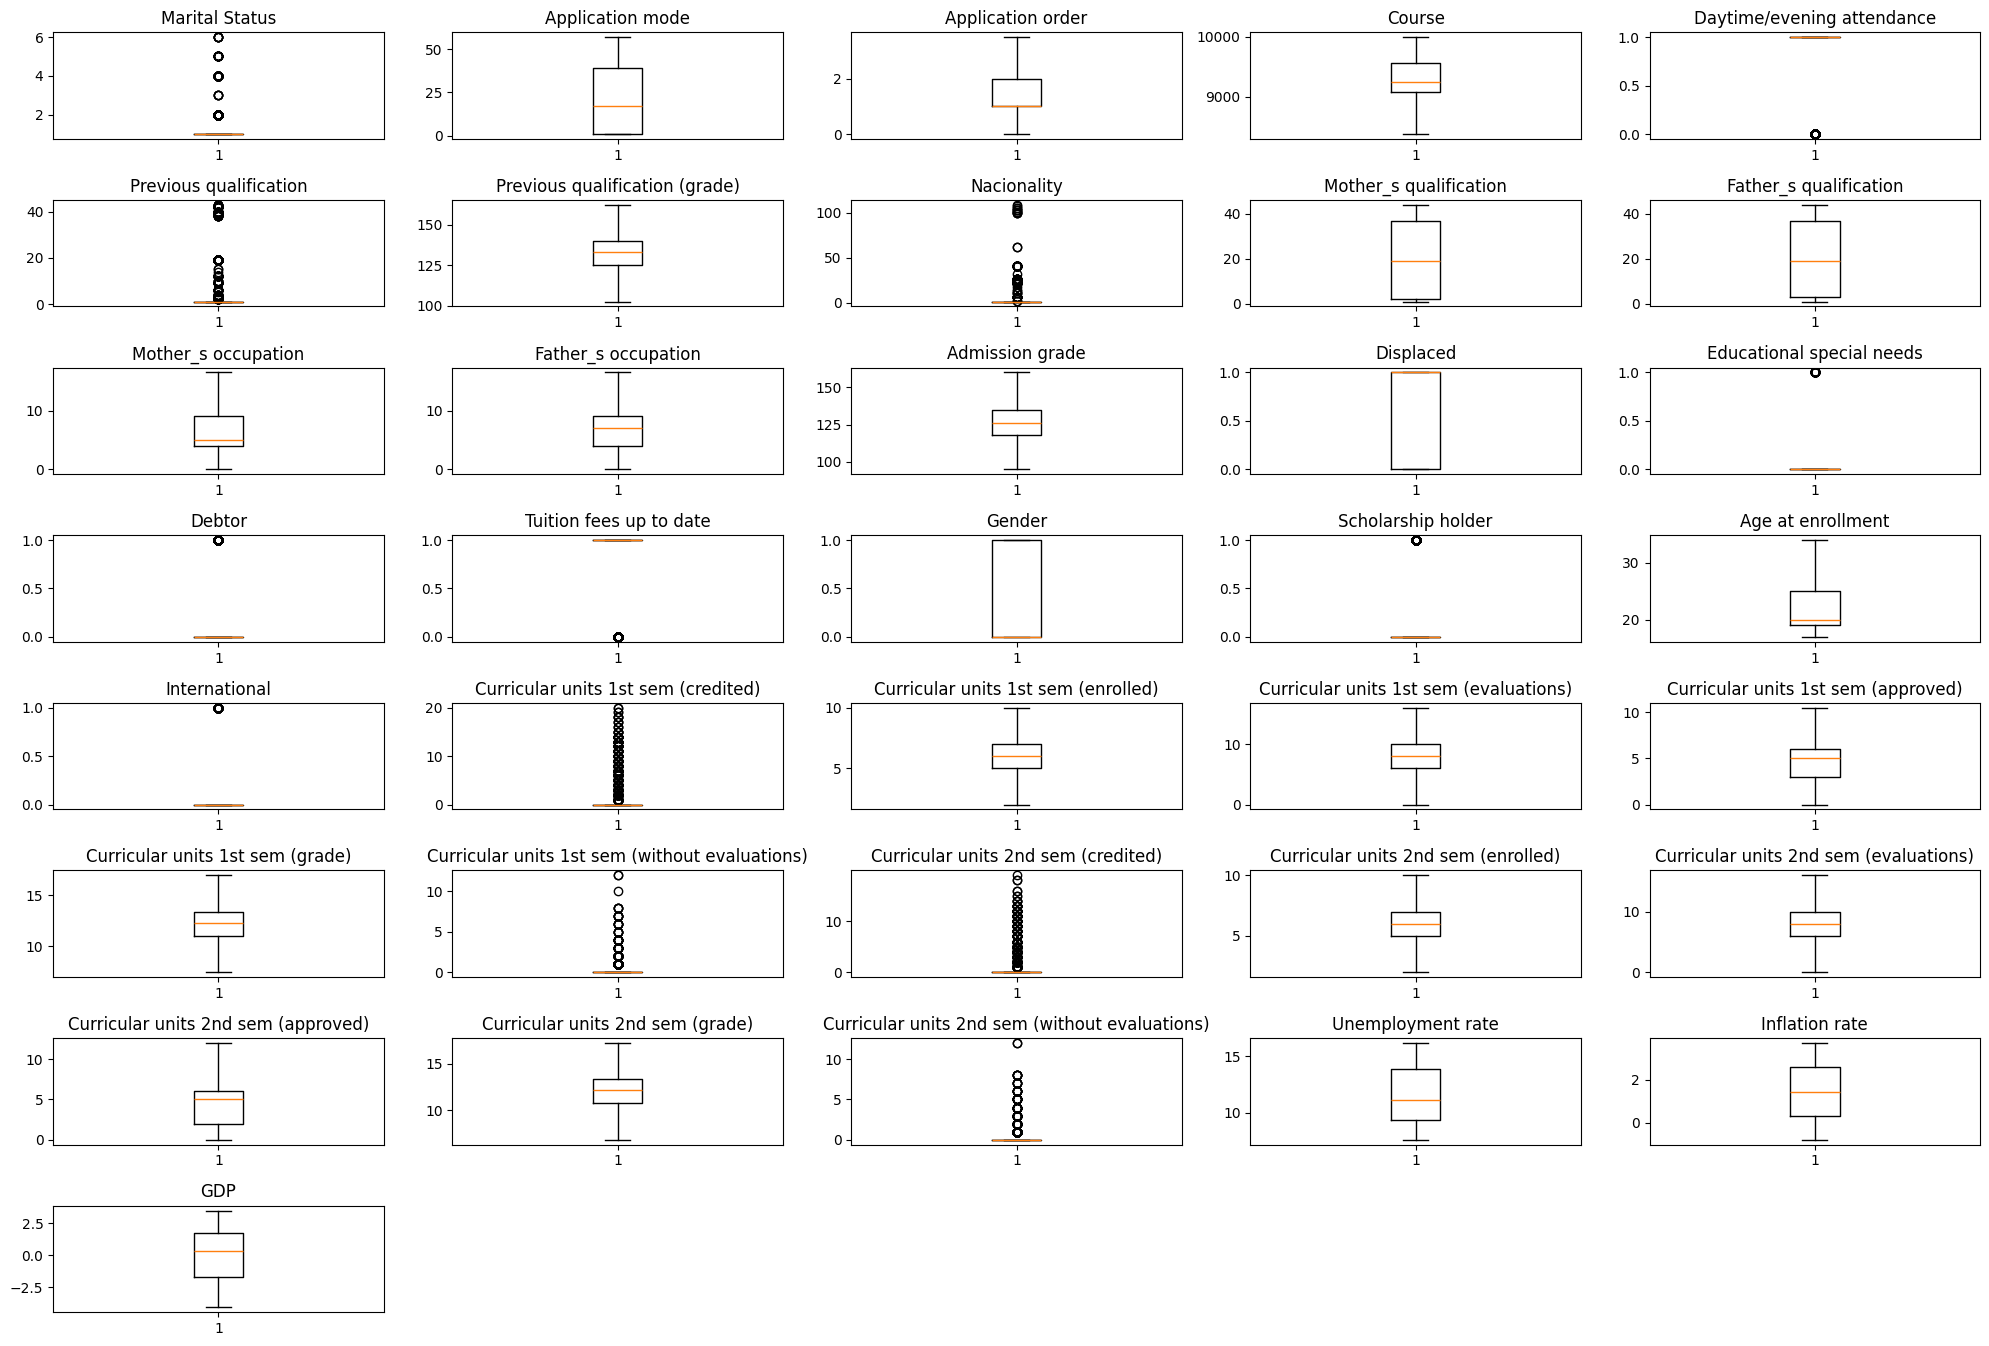

In [13]:
numerical_columns = df.select_dtypes(exclude="object")
plt.figure(figsize=(20,15))
for i,col in enumerate(numerical_columns.columns):
    plt.subplot(9,5,i+1)
    plt.boxplot(df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [14]:
df

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother_s qualification,Father_s qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,3.5,8378.5,1,1,122.0,1,19,12,...,0,2.0,0.0,0.0,6.875000,0,10.8,1.4,1.74,Dropout
1,1,15,1.0,9254.0,1,1,160.0,1,1,3,...,0,6.0,6.0,6.0,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,3.5,9070.0,1,1,122.0,1,37,37,...,0,6.0,0.0,0.0,6.875000,0,10.8,1.4,1.74,Dropout
3,1,17,2.0,9773.0,1,1,122.0,1,38,37,...,0,6.0,10.0,5.0,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1.0,8378.5,0,1,102.5,1,37,38,...,0,6.0,6.0,6.0,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,3.5,9773.0,1,1,125.0,1,1,1,...,0,6.0,8.0,5.0,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2.0,9773.0,1,1,120.0,105,1,1,...,0,6.0,6.0,2.0,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1.0,9500.0,1,1,154.0,1,37,37,...,0,8.0,9.0,1.0,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1.0,9147.0,1,1,162.5,1,37,37,...,0,5.0,6.0,5.0,12.000000,0,9.4,-0.8,-3.12,Graduate


## 3. EXPLORATORY DATA ANALYSIS (EDA)

### a) Analyze historical student performance

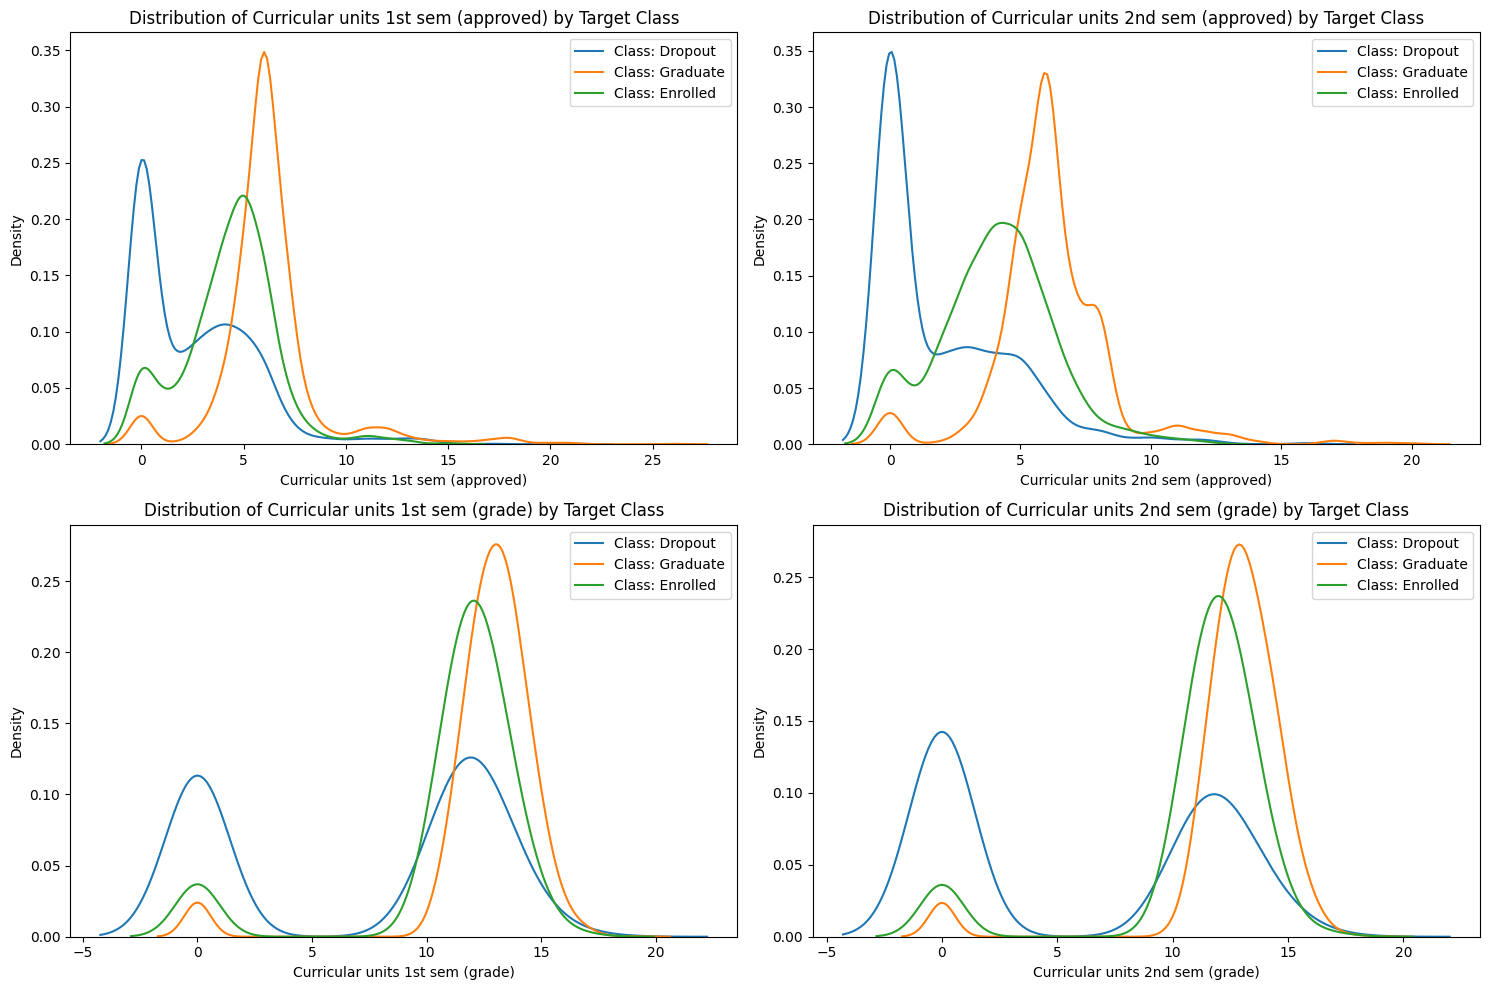

In [15]:
#creating a figure for key performance metrics across different target classes
plt.figure(figsize=(15, 10))

##academic performance metrics
performance_metrics = [
    'Curricular units 1st sem (approved)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (grade)'
]

for i, metric in enumerate(performance_metrics):
    plt.subplot(2, 2, i+1)
    for target_class in y['Target'].unique():
        sns.kdeplot(X[metric][y['Target'] == target_class],
                   label=f'Class: {target_class}')
    plt.title(f'Distribution of {metric} by Target Class')
    plt.legend()
plt.tight_layout()
plt.show()

### b) Highlighting high and low performing students

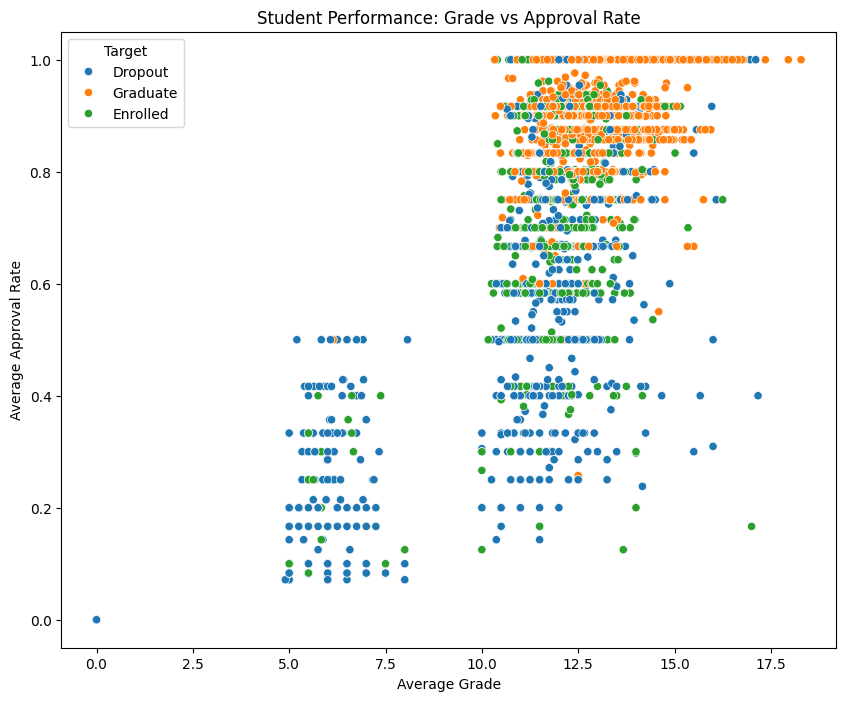

High/low performance visualization saved to 'high_low_performance.png'


In [16]:
## generating success metrics
X['overall_grade'] = (X['Curricular units 1st sem (grade)'] + X['Curricular units 2nd sem (grade)'])/2
X['approval_rate'] = (X['Curricular units 1st sem (approved)'] / X['Curricular units 1st sem (enrolled)'] +
                     X['Curricular units 2nd sem (approved)'] / X['Curricular units 2nd sem (enrolled)'])/2

plt.figure(figsize=(10, 8))
sns.scatterplot(x='overall_grade', y='approval_rate', hue=y['Target'], data=X)
plt.title('Student Performance: Grade vs Approval Rate')
plt.xlabel('Average Grade')
plt.ylabel('Average Approval Rate')
plt.show()
print("High/low performance visualization saved to 'high_low_performance.png'")

### c) Identify variables affecting student performance

In [17]:
X = df.drop(columns=["Target"])
y = df["Target"]

In [18]:
#splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
#standardizing numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
y_test

,Target
1853,Graduate
2399,Graduate
510,Enrolled
242,Graduate
3392,Graduate
...,...
555,Dropout
2418,Graduate
2367,Graduate
1801,Graduate


In [ ]:
# Preparing target variable
y_train = y_train.values
y_test = y_test.values

### c) Identifying key variables affecting performance

In [ ]:
# training a Random Forest to get feature importance
rf_initial = RandomForestClassifier(n_estimators=100, random_state=42)
rf_initial.fit(X_train_scaled, y_train)

importances = rf_initial.feature_importances_
indices = np.argsort(importances)[-15:]

# printing the top 5 most important features
print("Top 5 most important variables:")
for i in reversed(indices[-5:]):
    print(f"- {X.columns[i]}: {importances[i]:.4f}")

Top 5 most important variables:
- Curricular units 2nd sem (approved): 0.1453
- Curricular units 2nd sem (grade): 0.1074
- Curricular units 1st sem (approved): 0.0840
- Curricular units 1st sem (grade): 0.0667
- Admission grade: 0.0454


Key variables visualization saved to 'key_variables.png'


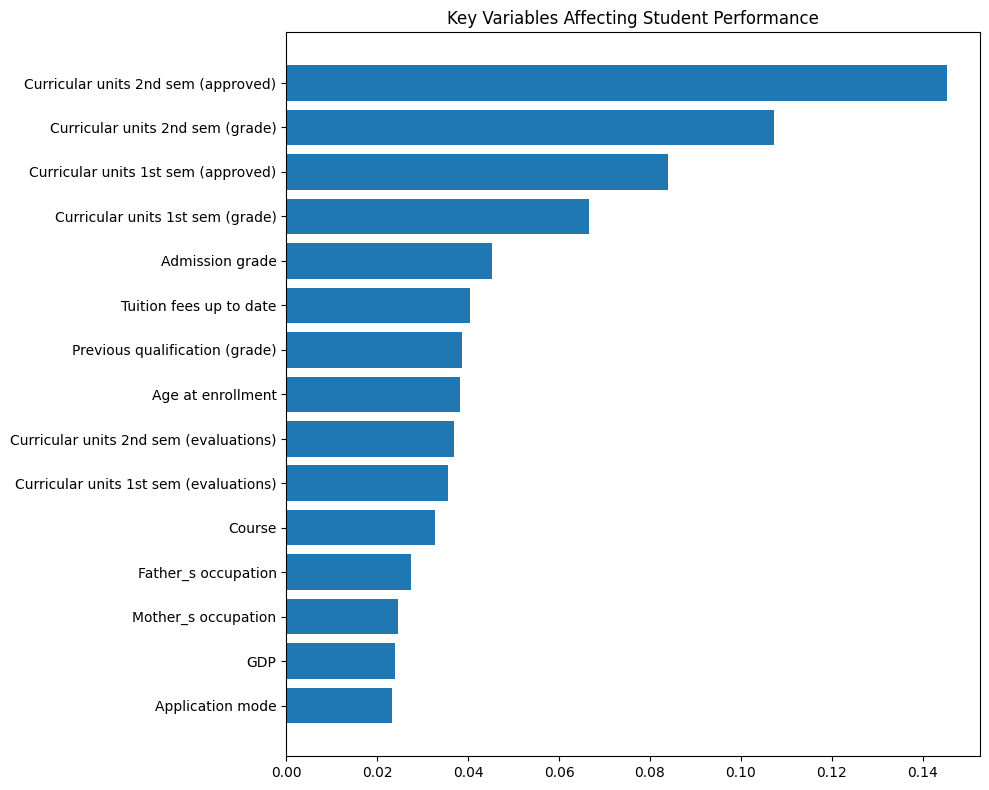

In [23]:
##plotting feature importance
plt.figure(figsize=(10, 8))
plt.title('Key Variables Affecting Student Performance')
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.tight_layout()
plt.savefig('key_variables.png')
print("Key variables visualization saved to 'key_variables.png'")

## 4. BUILD, EVALUATE, AND OPTIMIZE PREDICTIVE MODELS

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [25]:
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

results = {}

for name, clf in classifiers.items():
    print(f"Training {name}...")

    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    results[name] = {
        'test_accuracy': accuracy,
        'model': clf
    }

    print(f"{name} Test Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

Training Random Forest...
Random Forest Test Accuracy: 0.7706
Classification Report:
              precision    recall  f1-score   support

     Dropout       0.81      0.75      0.78       284
    Enrolled       0.57      0.37      0.45       159
    Graduate       0.79      0.93      0.85       442

    accuracy                           0.77       885
   macro avg       0.72      0.68      0.69       885
weighted avg       0.76      0.77      0.76       885

Training KNN...
KNN Test Accuracy: 0.6859
Classification Report:
              precision    recall  f1-score   support

     Dropout       0.74      0.68      0.71       284
    Enrolled       0.31      0.23      0.27       159
    Graduate       0.74      0.86      0.80       442

    accuracy                           0.69       885
   macro avg       0.60      0.59      0.59       885
weighted avg       0.67      0.69      0.67       885

Training Decision Tree...
Decision Tree Test Accuracy: 0.6712
Classification Report:
   

In [26]:
best_model_name = max(results, key=lambda x: results[x]['test_accuracy'])
best_model = results[best_model_name]['model']

print(f"Best model: {best_model_name} with an accuracy of {results[best_model_name]['test_accuracy']:.4f}")

Best model: Random Forest with an accuracy of 0.7706


### c) Validate the model based on data science experience

In [27]:
best_model.fit(X_train_scaled, y_train)
best_pred = best_model.predict(X_test_scaled)

### Confusion matrix

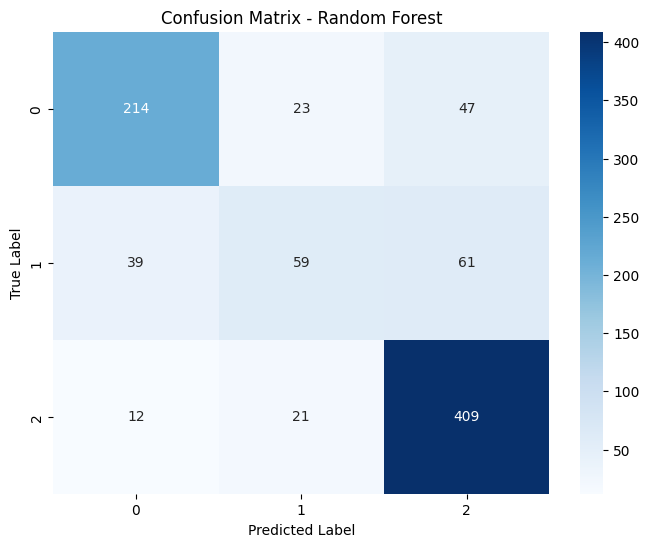

In [28]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Optimizing the best model with hyperparameter tuning

In [34]:
param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }

model_class = RandomForestClassifier

print("\nOptimizing model with hyperparameter tuning...")
grid_search = GridSearchCV(
    model_class(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted'
)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_ )


Optimizing model with hyperparameter tuning...
Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [35]:
final_model = grid_search.best_estimator_
final_pred = final_model.predict(X_test_scaled)
final_accuracy = accuracy_score(y_test, final_pred)
final_f1 = f1_score(y_test, final_pred, average='weighted')
print(f"Optimized {best_model_name} - Accuracy: {final_accuracy:.2f}, F1 Score: {final_f1:.4f}")

Optimized Random Forest - Accuracy: 0.78, F1 Score: 0.7641


- Demographic analysis

In [36]:

print("\nAnalyzing model performance across demographic groups:")
demographic_factors = ['Gender', 'Scholarship holder', 'Age at enrollment']

for factor in demographic_factors:
    if factor in X.columns:
        performance_by_factor = pd.DataFrame({
            'Factor': X_test[factor],
            'True': y_test,
            'Predicted': final_pred
        })

        accuracy_by_factor = performance_by_factor.groupby('Factor').apply(
            lambda x: accuracy_score(x['True'], x['Predicted'])
        )

        print(f"\nAccuracy by {factor}:")
        print(accuracy_by_factor)


Analyzing model performance across demographic groups:

Accuracy by Gender:
Factor
0    0.796491
1    0.746032
dtype: float64

Accuracy by Scholarship holder:
Factor
0    0.758824
1    0.843902
dtype: float64

Accuracy by Age at enrollment:
Factor
17.0    1.000000
18.0    0.750000
19.0    0.777143
20.0    0.709402
21.0    0.761194
22.0    0.846154
23.0    0.800000
24.0    0.766667
25.0    0.789474
26.0    0.687500
27.0    0.757576
28.0    0.947368
29.0    0.750000
30.0    0.750000
31.0    0.866667
32.0    1.000000
33.0    0.777778
34.0    0.858696
dtype: float64


In [37]:
print("final recommendation")
print(f"Based on comprehensive evaluation, the optimized {best_model_name} is recommended for")
print("predicting student academic performance in higher education settings.")
print(f"This model achieves {final_accuracy:.2%} accuracy and {final_f1:.4f} F1 score,")
print("making it effective at identifying students at risk of dropping out or facing academic challenges.")
print("\nKey predictive factors include:")
if hasattr(final_model, 'feature_importances_'):
    top_indices = np.argsort(final_model.feature_importances_)[-5:]
    for i in reversed(top_indices):
        print(f"- {X.columns[i]}")

final recommendation
Based on comprehensive evaluation, the optimized Random Forest is recommended for
predicting student academic performance in higher education settings.
This model achieves 77.85% accuracy and 0.7641 F1 score,
making it effective at identifying students at risk of dropping out or facing academic challenges.

Key predictive factors include:
- Curricular units 2nd sem (approved)
- Curricular units 2nd sem (grade)
- Curricular units 1st sem (approved)
- Curricular units 1st sem (grade)
- Admission grade
